В данном датасете мы рассмотрим данные о 5000 кинофильмах с портала tmdb. В данном датасете будет проведен анализ данных с целью поиска ответов на следующие вопросы:

1. Какой самый популярный киножанр до 1990 года / после 1990 года
2. Действительно ли фильмы современного популярного до 1990 года были лучше, то есть имеет больший средний рейтинг
3. Как можно предсказать уровень доходности фильма

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Загрузим датасет из портала tmbd. Часть данных в датасете представлена в виде json структуры, которую необходимо распарсить и представить в виде строки с разделителями

In [2]:
def pipe_flatten_names(column):
    """Функция принимает столбец данных распарсенного json словаря
    выделяет совйство name и записывает значение в строку с разделителем |
    если таких несколько"""
    
    return '|'.join([x['name'] for x in column])

In [3]:
def load_tmdb_movies(path):
    """Функция загружает датасет, преобразовывает датру,
    парсит json словарь и сохраняет данные в датафрейм"""
    
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries',
                   'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
        df[column] = df[column].apply(pipe_flatten_names)
    return df

In [4]:
data = load_tmdb_movies('tmdb_5000_movies.csv')

In [5]:
data.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,Action|Adventure|Fantasy|Science Fiction,http://www.avatarmovie.com/,19995,culture clash|future|space war|space colony|so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009-12-10,2787965087,162.0,English|Español,Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,Adventure|Fantasy|Action,http://disney.go.com/disneypictures/pirates/,285,ocean|drug abuse|exotic island|east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007-05-19,961000000,169.0,English,Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,Action|Adventure|Crime,http://www.sonypictures.com/movies/spectre/,206647,spy|based on novel|secret agent|sequel|mi6|bri...,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,Columbia Pictures|Danjaq|B24,United Kingdom|United States of America,2015-10-26,880674609,148.0,Français|English|Español|Italiano|Deutsch,Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,Action|Crime|Drama|Thriller,http://www.thedarkknightrises.com/,49026,dc comics|crime fighter|terrorist|secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,Legendary Pictures|Warner Bros.|DC Entertainme...,United States of America,2012-07-16,1084939099,165.0,English,Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,Action|Adventure|Science Fiction,http://movies.disney.com/john-carter,49529,based on novel|mars|medallion|space travel|pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,Walt Disney Pictures,United States of America,2012-03-07,284139100,132.0,English,Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
homepage                1712 non-null object
id                      4803 non-null int64
keywords                4803 non-null object
original_language       4803 non-null object
original_title          4803 non-null object
overview                4800 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4802 non-null object
revenue                 4803 non-null int64
runtime                 4801 non-null float64
spoken_languages        4803 non-null object
status                  4803 non-null object
tagline                 3959 non-null object
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null 

Датасет содержит много тестовых значений. Для нашей задачи выявления самых популярных жанров необходимо преобразовать данные по жанрам и выделить год из даты. Для того, чтобы построить статистику по жанрам выделим уникальные значения жанров и преобразуем их в one-hot столбцы, где для каждого жанра определяется соответствие фильма жанру (значение 1) или не соответствует (хначение 0)

In [7]:
def get_year(date):
    return date.year

def split_object(df, column):
    """Фнукция возращает множество уникальных значений данных столбца"""
    set_column = set()
    for row in data[column]:
        for j in row.split('|'):       
            set_column.add(j)  
    return set_column

def one_hot_genre_encoding(df, set_column, column):
    """Функция принимает уникальное множество значений столбца и преобразует их в 
    one-hot столбцы датафрейма"""
    for obj in set_column:
        labels = []
        if obj:
            for i in range(len(df)):
                if obj in df.loc[i][column]:
                    labels.append(1)
                else:
                    labels.append(0)           
            df[obj] = labels
        else:
            continue
    return df

Для выполнения поставленных задач не требуются все данные датасета. Напишем функцию, которая удалит ненужные текстовые данные, преобразует данные по жанрам и отберет только выпущенные в продакшн фильмы

In [8]:
def prepare_data(df):  
    
    remove_cols = ['genres', 'homepage', 'keywords', 'spoken_languages', 'overview', 'original_title',
                  'tagline', 'release_date', 'status','title','production_countries', 'production_companies', 
                   'original_language']
    df['year'] = df['release_date'].apply(get_year)
    genres = split_object(data, 'genres')
    df = one_hot_genre_encoding(df, genres, 'genres')
    df = df.loc[df['status'] == 'Released']
    df.drop(remove_cols, axis=1, inplace=True)   
    return df

Подготовим данные

In [9]:
data = prepare_data(data)

C:\Anaconda\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [10]:
data.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count,year,Horror,TV Movie,...,History,Thriller,War,Action,Romance,Crime,Foreign,Mystery,Family,Music
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800,2009.0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,300000000,285,139.082615,961000000,169.0,6.9,4500,2007.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,245000000,206647,107.376788,880674609,148.0,6.3,4466,2015.0,0,0,...,0,0,0,1,0,1,0,0,0,0
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106,2012.0,0,0,...,0,1,0,1,0,1,0,0,0,0
4,260000000,49529,43.926995,284139100,132.0,6.1,2124,2012.0,0,0,...,0,0,0,1,0,0,0,0,0,0


Рассчитаем среднюю поппулярность жанров фильмов, выпущенных до 1990 года и после 1990 года

In [11]:
def get_genre_info_by_year(df, genres, year_condition):
    """Функция принимает датасет с данными, массив с жанрами и условие отбора
       возвращает датафярейм, содержащий название жанра и его среднее значение популярности"""
    
    genre_pop_means = []    
    for g in genres:
        clean_df = df.loc[year_condition & (df[g] == 1), 'popularity']
        popular_mean = clean_df.mean()
        genre_pop_means.append(popular_mean)
    genre_data = pd.DataFrame({'genre': genres, 'mean_popularity': genre_pop_means}).\
                                sort_values('mean_popularity', ascending=False)
    genre_data.loc[genre_data['mean_popularity'].isna(), 'mean_popularity'] = 0
    return genre_data

In [12]:
genres = data.columns[8:]
before_1990 = get_genre_info_by_year(data, genres, data['year'] <= 1990)
after_1990 = get_genre_info_by_year(data, genres, data['year'] > 1990)
before_1990.set_index('genre', inplace=True)
after_1990.set_index('genre', inplace=True)
before_1990.head()

,mean_popularity
genre,
Animation,33.689709
Fantasy,25.680032
Science Fiction,24.753144
Adventure,23.713802
Family,22.935002


Построим столбчатую диаграмму средней популярности жанров за 2 периода

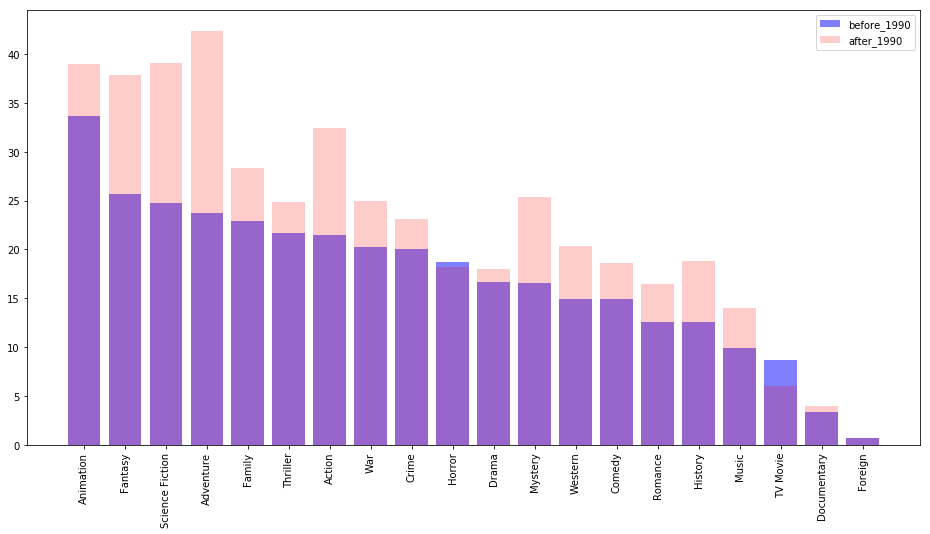

In [13]:
plt.figure(figsize=(16,8))
plt.bar(before_1990.index, before_1990 ['mean_popularity'], color='b', alpha=0.5, label='before_1990')
plt.bar(after_1990.index, after_1990 ['mean_popularity'], color='r', alpha=0.2, label='after_1990')
plt.xticks(rotation='90')
plt.legend();

До 1990 года самым популярным жанром были анимационные фильмы, фентези и научная фантастика. но после 1990 года  в лидеры вырывается приключенческое кино. При этом анимационные фильмы, фентези и научная фантастика сохраняют свои позиции. Так же в это время заметен рехкий скачок популярности на экшены и мистику. Посмотри 5 жанров, которые имеют наибольшую динамику роста популярности в последнее время

In [14]:
best_popularity = np.abs(before_1990 - after_1990).sort_values(by='mean_popularity', ascending=False)[:5]
best_popularity

,mean_popularity
genre,
Adventure,18.702967
Science Fiction,14.313250
Fantasy,12.138430
Action,10.874172
Mystery,8.731739


Как и на графике лидером становятся приключенческие фильмы. Проверим с помощью однофакторного дисперсионного анализа действительтно ли приключенческие фильмы выпущенные после 1990 года в среднем лучше приключений выпущенных до 1990 года

In [15]:
from scipy import stats

In [16]:
def variance_analysis(y, y1, y2, alpha=0.05):
    """Реализация дисперсионного анализа. Функция выводит статистическую значимость
    разницы средних"""
    y1_mean = y1.mean()
    y2_mean = y2.mean()
    y_mean  = y.mean()
    n1 = y1.shape[0]
    n2 = y2.shape[0]
    print(f'среднее y1 = {round(y1_mean, 2)}\n'
          f'среднее y2 = {round(y2_mean, 2)}')
    S2_F = n1 * (y1_mean - y_mean) ** 2 + n2 * (y2_mean - y_mean) ** 2
    S2_res = ((y1  - y1_mean) ** 2).sum() + ((y2 - y2_mean) ** 2).sum() 
   
    k = 2
    n = n1 + n2
    k1 = k - 1
    k2 = n - k
    sigma2_F = S2_F / k1
    sigma2_res = S2_res / k2        
    T = sigma2_F / sigma2_res
    F_crit = stats.f.ppf(1 - alpha, k1, k2)

    if T > F_crit:
        print(f'T {round(T, 2)} > F_crit {round(F_crit, 2)}, Разница средних статистически значима')
    else:
        print(f'T {round(T, 2)} <= F_crit {round(F_crit, 2)}, Разница средних статистически незначима')    

In [17]:
y1 = data.loc[(data['Adventure'] == 1) & (data['year'] <= 1990), 'vote_average']
y2 = data.loc[(data['Adventure'] == 1) & (data['year'] > 1990), 'vote_average']
y =  data.loc[(data['Adventure'] == 1), 'vote_average']
variance_analysis(y, y1, y2)

среднее y1 = 6.43
среднее y2 = 6.1
T 14.75 > F_crit 3.85, Разница средних статистически значима


Приключения до 1990 года имеют больший средний рейтинг (6.43) чем приключения вышедшие после (6.1). Возможно это связано с тем, что приключенческие фильмы приносят больше дохода и много кинокомпаний просто ради выгоды клепают кино по шаблону. Проверим, что современные приключенческие фильмы приносят больше дохода

In [18]:
y1 = data.loc[(data['Adventure'] == 1) & (data['year'] <= 1990), 'revenue']
y2 = data.loc[(data['Adventure'] == 1) & (data['year'] > 1990), 'revenue']
y =  data.loc[(data['Adventure'] == 1), 'revenue']
variance_analysis(y, y1, y2)

среднее y1 = 100704144.84
среднее y2 = 230514323.12
T 23.67 > F_crit 3.85, Разница средних статистически значима


Средний доход от прокатов приключенческих фильмов после 1990 года вырос более чем в 2 раза. Неизвестно, как в данных учитывается инфляция, но мы видим значительный прирост доходности

С помощью коэффициента корреляции Пирсона посмотрим какиеи факторы влияют на доходность фильма

In [19]:
data = data.loc[(data['revenue'] > 0) & (data['budget'] > 0)] #Отбор фильмо с известным бюджетом и доходом
data.corr()['revenue'].sort_values(ascending=False)

revenue            1.000000
vote_count         0.756177
budget             0.705353
popularity         0.602186
Adventure          0.344104
runtime            0.233073
Fantasy            0.216269
Animation          0.210431
Family             0.200386
Action             0.187926
vote_average       0.187659
year               0.147604
Science Fiction    0.142215
id                 0.030131
War               -0.021624
Foreign           -0.025559
Mystery           -0.030833
Thriller          -0.037593
Western           -0.039949
Music             -0.042764
Comedy            -0.049745
History           -0.050481
Documentary       -0.055921
Romance           -0.071691
Crime             -0.078603
Horror            -0.097334
Drama             -0.189108
TV Movie                NaN
Name: revenue, dtype: float64

Мы видим, что значение дохода существенно зависмит от количество людей, посмотревших фильм и поставивших оценку, от размера бюджета и уровня популярности. Так же среди жанров наибольшее влияние на доходность оказывает "приключение".

Попробуем предсказать доходность фильма с помощью линейной регрессии. Так как для будущего фильма среди существенно линейно зависимых факторов известен бюджет, то попробуем построить уравнения зависимости доходности фильма от его бюджета

Посмотрим количество уникальных значений бюджета

In [20]:
data['budget'].nunique()

385

На одно значение бюджета приходится несколько значений доходности. Поэтому мы будем предсказывать средний доход в зависимости от бюджета фильма

Вычислим среднюю доходность по бюджетам


In [21]:
r_data = data.groupby(['budget'], as_index=False)['revenue'].mean().\
        rename(columns={'revenue': 'mean_revenue'})
X = np.array(r_data['budget']).reshape(-1 ,1)
y = np.array(r_data['mean_revenue']).reshape(-1, 1)

Разделим выборку на обучающую и тестовую, затем обучим на ней модель линейой регрессии основаной на методе наименьших квадратов

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [24]:
class LinearRegression():
    def __init__(self):
        self._b0 = None
        self._b1 = None

    def fit(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((X, ones))       
        XTX = X.T.dot(X)
        det = np.linalg.det(XTX)
       
        if det != 0:
            XTX_inv = np.linalg.inv(XTX)
            b = XTX_inv.dot(X.T).dot(y)            
            self._b0 = b[1, 0]
            self._b1 = b[0, 0]
        else:
            raise Exception('Определитель равен нулю')
            
        return self
    
    def predict(self, X_test):
        return self._b0 + self._b1 * X_test
            

In [25]:
model = LinearRegression()
model.fit(X_train, y_train)
pred = model.predict(X_test)

In [26]:
r2_score(y_test, pred)

0.8326357140546665

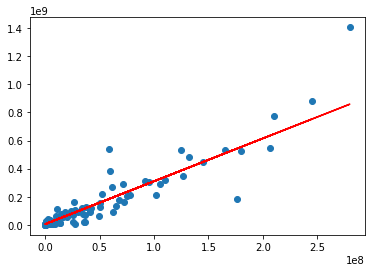

In [27]:
plt.scatter(X_test, y_test)
plt.plot(X_test, pred, color='r');

Модель достаточно хороша описывает средний доход от уровня бюджета. Уравнение регрессии имеет вид

In [28]:
print(f' y = {model._b0} + {model._b1} * x')

 y = 6481566.3521673065 + 3.0423650186109237 * x
